In [1]:
import pandas as pd
import numpy as np

# Cargar los datos
data = pd.read_csv("E:/Bootcamp/hospital/insurance.csv")

# Vista inicial de los datos
print("Estructura de los datos:")
print(data.info())
print("\nPrimeras filas:")
print(data.head())

# Resumen estadístico
print("\nResumen estadístico:")
print(data.describe())

# Comprobar valores nulos
print("\nValores nulos por columna:")
print(data.isnull().sum())


Estructura de los datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None

Primeras filas:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

Resumen estadístico:
               age         

In [2]:
# Manejar valores nulos (si existen)
data.fillna(data.median(numeric_only=True), inplace=True)

# Identificar y manejar outliers
from scipy.stats import zscore

z_scores = np.abs(zscore(data.select_dtypes(include=[np.number])))
threshold = 3
outliers = np.where(z_scores > threshold)

print(f"Cantidad de outliers detectados: {len(outliers[0])}")

# Filtrar outliers (opcional)
data = data[(z_scores < threshold).all(axis=1)]


Cantidad de outliers detectados: 29


In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Separar características y target
X = data.drop("charges", axis=1)
y = data["charges"]

# Identificar variables categóricas y numéricas
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns

# Crear transformaciones
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nPreprocesamiento completado.")



Preprocesamiento completado.


In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Definir modelos
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42)
}

# Evaluar modelos
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print(f"\n{name}:")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
    print(f"R2 Score: {r2_score(y_test, y_pred):.2f}")



Linear Regression:
RMSE: 5517.62
R2 Score: 0.78

Decision Tree:
RMSE: 5850.01
R2 Score: 0.75

Random Forest:
RMSE: 4283.25
R2 Score: 0.87


In [5]:
from sklearn.model_selection import GridSearchCV

# Definir hiperparámetros para Random Forest
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5, 10]
}

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', RandomForestRegressor(random_state=42))])

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\nMejores hiperparámetros (GridSearchCV):")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_



Mejores hiperparámetros (GridSearchCV):
{'model__max_depth': 10, 'model__min_samples_split': 10, 'model__n_estimators': 200}


In [6]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5, 10]
}

random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=10, cv=3, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

print("\nMejores hiperparámetros (RandomizedSearchCV):")
print(random_search.best_params_)


c:\Users\chave\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Mejores hiperparámetros (RandomizedSearchCV):
{'model__n_estimators': 200, 'model__min_samples_split': 10, 'model__max_depth': 10}


In [7]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Función objetivo para Optuna
def objective(trial):
    # Definir el espacio de búsqueda de hiperparámetros
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)

    # Crear el modelo con los hiperparámetros sugeridos
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )

    # Crear pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    
    # Validación cruzada
    scores = cross_val_score(pipeline, X_train, y_train, cv=3, scoring='neg_mean_squared_error')
    return -scores.mean()  # Optuna busca minimizar esta métrica

# Crear el estudio de optimización
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Resultados del estudio
print("\nMejores hiperparámetros encontrados por Optuna:")
print(study.best_params)

# Entrenar modelo con los mejores hiperparámetros
best_params = study.best_params
final_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    random_state=42
)

final_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', final_model)])
final_pipeline.fit(X_train, y_train)

# Evaluar en el conjunto de prueba
y_pred = final_pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nResultados del modelo optimizado:")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")


c:\Users\chave\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-11-26 15:53:41,606] A new study created in memory with name: no-name-95d55678-126e-4d18-8f51-ac1eb576bc41
[I 2024-11-26 15:53:43,824] Trial 0 finished with value: 22355486.0510962 and parameters: {'n_estimators': 419, 'max_depth': 18, 'min_samples_split': 13}. Best is trial 0 with value: 22355486.0510962.
[I 2024-11-26 15:53:46,483] Trial 1 finished with value: 22729101.76874793 and parameters: {'n_estimators': 459, 'max_depth': 22, 'min_samples_split': 9}. Best is trial 0 with value: 22355486.0510962.
[I 2024-11-26 15:53:48,201] Trial 2 finished with value: 22044049.914985646 and parameters: {'n_estimators': 346, 'max_depth': 45, 'min_samples_split': 20}. Best is trial 2 with value: 22044049.914985646.
[


Mejores hiperparámetros encontrados por Optuna:
{'n_estimators': 362, 'max_depth': 50, 'min_samples_split': 20}

Resultados del modelo optimizado:
RMSE: 3969.78
R2 Score: 0.89


In [8]:
# Evaluación del modelo inicial
initial_model = RandomForestRegressor(random_state=42)
initial_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', initial_model)])
initial_pipeline.fit(X_train, y_train)

y_pred_initial = initial_pipeline.predict(X_test)
rmse_initial = np.sqrt(mean_squared_error(y_test, y_pred_initial))
r2_initial = r2_score(y_test, y_pred_initial)

print("\nComparación de Resultados:")
print(f"Modelo Inicial -> RMSE: {rmse_initial:.2f}, R2 Score: {r2_initial:.2f}")
print(f"Modelo Optimizado -> RMSE: {rmse:.2f}, R2 Score: {r2:.2f}")



Comparación de Resultados:
Modelo Inicial -> RMSE: 4283.25, R2 Score: 0.87
Modelo Optimizado -> RMSE: 3969.78, R2 Score: 0.89


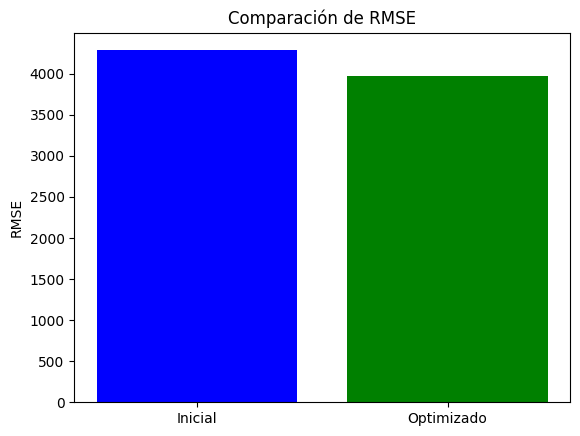

In [9]:
import matplotlib.pyplot as plt

# Comparar RMSE
labels = ['Inicial', 'Optimizado']
rmse_values = [rmse_initial, rmse]

plt.bar(labels, rmse_values, color=['blue', 'green'])
plt.title('Comparación de RMSE')
plt.ylabel('RMSE')
plt.show()
